# MobileNet v2 with CIFAR10

## Librerías

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchinfo import summary

import torchvision
from torchvision import models
import torchvision.transforms as transforms

import torchattacks

from utils.datasets import MyDataset
from utils.evaluation import NormalizationLayer, get_topk_accuracy
from utils.evaluation import plot_adversarial, get_same_predictions, get_different_predictions
from utils.mobilenetv2 import build_mobilenet_v2

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Modelo

Tengo dos modelos, uno que ha sido entrenado con ejemplos adversarios y otro que no.

In [4]:
mobilenet_v2 = nn.Sequential(
    NormalizationLayer(mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616]),
    build_mobilenet_v2(pretrained=False))

mobilenet_v2.load_state_dict(torch.load('models/mobilenet_v2.pt'))
mobilenet_v2.eval()

# Lo movemos a la GPU, en caso de que haya
mobilenet_v2 = mobilenet_v2.to(device)

In [5]:
mobilenet_v2_adversarial = nn.Sequential(
    NormalizationLayer(mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616]),
    build_mobilenet_v2(pretrained=False))

mobilenet_v2_adversarial.load_state_dict(torch.load('models/mobilenet_v2_adversarial.pt'))
mobilenet_v2_adversarial.eval()

# Lo movemos a la GPU, en caso de que haya
mobilenet_v2_adversarial = mobilenet_v2_adversarial.to(device)

## Datasets & dataloaders

Ejecutaré los ataques en el dataset de prueba y evaluaré qué tal se desempeñan ambos modelos.

In [6]:
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 32

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

Files already downloaded and verified


## Ataques

Los siguientes son todos los ataques que están disponibles en [Adversarial-Attacks-PyTorch](https://github.com/Harry24k/adversarial-attacks-pytorch):

```python
attacks = [torchattacks.FGSM(model, eps=8/255),
           torchattacks.BIM(model, eps=8/255, alpha=2/255, steps=7),
           torchattacks.CW(model, c=1, kappa=0, steps=1000, lr=0.01),
           torchattacks.RFGSM(model, eps=8/255, alpha=4/255, steps=1),
           torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=7),
           torchattacks.FFGSM(model, eps=8/255, alpha=12/255),
           torchattacks.TPGD(model, eps=8/255, alpha=2/255, steps=7),
           torchattacks.MIFGSM(model, eps=8/255, decay=1.0, steps=5),
           torchattacks.APGD(model, eps=8/255, steps=10),
           torchattacks.FAB(model, eps=8/255),
           torchattacks.Square(model, eps=8/255),
           torchattacks.PGDDLR(model, eps=8/255, alpha=2/255, steps=7),
           torchattacks.DeepFool(model, steps=50, overshoot=0.02),
           torchattacks.OnePixel(model, pixels=1, steps=75, popsize=400),
           torchattacks.SparseFool(model, steps=20, lam=3, overshoot=0.02)]
```

No probaré todos ya que son bastantes, por lo que tomaré:

- `torchattacks.FGSM`: fue el primer algortimo para generar ataques, ver [Explaining and harnessing adversarial examples (Goodfellow et al., 2014)](https://arxiv.org/abs/1412.6572).
- `torchattacks.PGD`: uno de los algoritmos que usa el gradiente, he visto que lo usan en varios lugares, ver [Towards Deep Learning Models Resistant to Adversarial Attacks (Mardry et al., 2017)](https://arxiv.org/abs/1706.06083).
- `torchattacks.MIFGSM`: también usa el gradiente pero le añade momento, ver [Boosting Adversarial Attacks with Momentum (Dong et al., 2017)](https://arxiv.org/abs/1710.06081). Este algoritmo fue uno de los ganadores de la competencia [NIPS 2017: Non-targeted Adversarial Attack
](https://www.kaggle.com/c/nips-2017-non-targeted-adversarial-attack/overview).
- `torchattacks.OnePixel`: ataque a un sólo pixel, quiero jugar con este algoritmo sólo para ver qué tan robustas son las redes que usaré y está divertido, ver [One pixel attack for fooling deep neural networks (Su et al., 2019)](https://arxiv.org/abs/1710.08864).


### FGSM

In [7]:
%%time

attack = torchattacks.FGSM(mobilenet_v2, eps=1/255)
attack.set_return_type('float') 
attack.save(testloader, save_path='models/FGSM_test.pt', verbose=True)

- Save Progress: 100.00 % / Accuracy: 37.03 % / L2: 0.21683
- Save Complete!
CPU times: user 14.1 s, sys: 430 ms, total: 14.5 s
Wall time: 11.5 s


### PGD

In [8]:
%%time

attack = torchattacks.PGD(mobilenet_v2, eps=1/255, alpha=1/255, steps=3)
attack.set_return_type('float') 
attack.save(testloader, save_path='models/PGD_test.pt', verbose=True)

- Save Progress: 100.00 % / Accuracy: 28.29 % / L2: 0.20759
- Save Complete!
CPU times: user 29.8 s, sys: 681 ms, total: 30.4 s
Wall time: 26.3 s


### MIFGSM

In [9]:
%%time

attack = torchattacks.MIFGSM(mobilenet_v2, eps=1/255, decay=1.0, steps=3)
attack.set_return_type('float') 
attack.save(testloader, save_path='models/MIFGSM_test.pt', verbose=True)

- Save Progress: 100.00 % / Accuracy: 31.27 % / L2: 0.20112
- Save Complete!
CPU times: user 30 s, sys: 629 ms, total: 30.6 s
Wall time: 26.3 s


### OnePixel

In [10]:
%%time

attack = torchattacks.OnePixel(mobilenet_v2, pixels=1, steps=5, popsize=20)
attack.set_return_type('float') 
attack.save(testloader, save_path='models/OnePixel_test.pt', verbose=True)

- Save Progress: 100.00 % / Accuracy: 63.17 % / L2: 0.81522
- Save Complete!
CPU times: user 6min 40s, sys: 816 ms, total: 6min 41s
Wall time: 6min 37s


## Evaluación en mobilenet_v2

### Limpio

In [11]:
dataloader_eval  = torch.utils.data.DataLoader(testset, batch_size=None, shuffle=False, num_workers=4)

y_true, y_pred, accuracy_1, accuracy_5 = get_topk_accuracy(mobilenet_v2, dataloader_eval)
print(f'Accuracy@1: {accuracy_1}')

100%|██████████| 10000/10000 [00:45<00:00, 220.13it/s]

Accuracy@1: 81.67999999999999


### FGSM

In [12]:
# The adversarial images are in [0,1], so NormalizationLayer prepares them for the pre-trained model 
adv_images, adv_labels = torch.load('models/FGSM_test.pt')
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true_adv, y_pred_adv, accuracy_1, accuracy_5 = get_topk_accuracy(mobilenet_v2, adv_loader)
print(f'Accuracy@1: {accuracy_1}')

100%|██████████| 10000/10000 [00:47<00:00, 209.24it/s]


Accuracy@1: 37.03


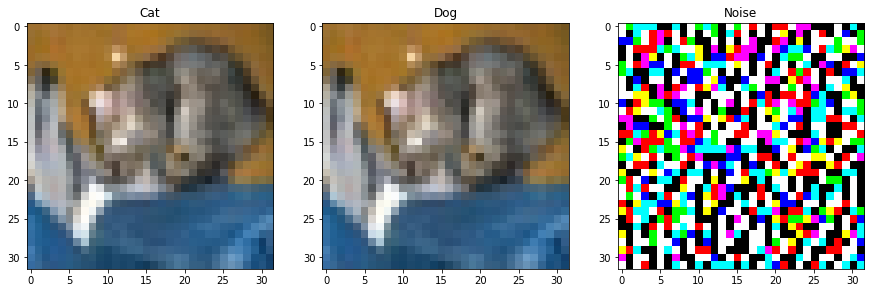

In [13]:
i = 0
plot_adversarial(testset, adv_dataset, y_pred, y_pred_adv, i)

### PGD

In [14]:
# The adversarial images are in [0,1], so NormalizationLayer prepares them for the pre-trained model 
adv_images, adv_labels = torch.load('models/PGD_test.pt')
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true_adv, y_pred_adv, accuracy_1, accuracy_5 = get_topk_accuracy(mobilenet_v2, adv_loader)
print(f'Accuracy@1: {accuracy_1}')

100%|██████████| 10000/10000 [00:49<00:00, 203.71it/s]


Accuracy@1: 28.29


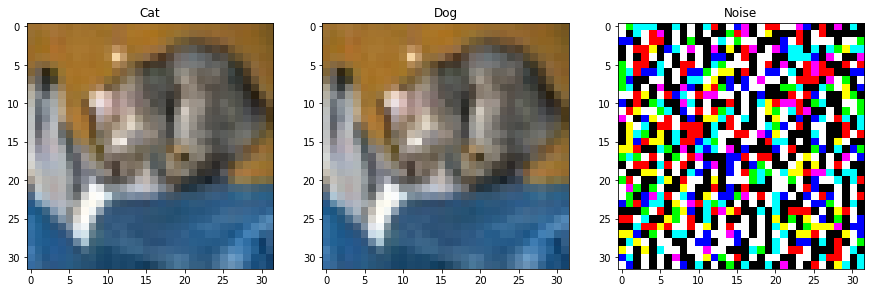

In [15]:
i = 0
plot_adversarial(testset, adv_dataset, y_pred, y_pred_adv, i)

### MIFGSM

In [16]:
# The adversarial images are in [0,1], so NormalizationLayer prepares them for the pre-trained model 
adv_images, adv_labels = torch.load('models/MIFGSM_test.pt')
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true_adv, y_pred_adv, accuracy_1, accuracy_5 = get_topk_accuracy(mobilenet_v2, adv_loader)
print(f'Accuracy@1: {accuracy_1}')

100%|██████████| 10000/10000 [00:48<00:00, 204.51it/s]


Accuracy@1: 31.269999999999996


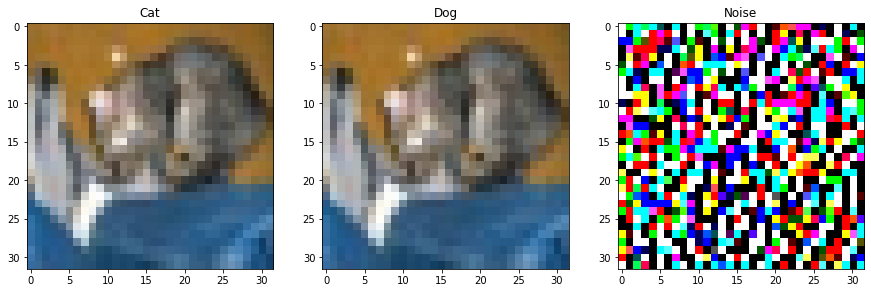

In [17]:
i = 0
plot_adversarial(testset, adv_dataset, y_pred, y_pred_adv, i)

### OnePixel

In [18]:
# The adversarial images are in [0,1], so NormalizationLayer prepares them for the pre-trained model 
adv_images, adv_labels = torch.load('models/OnePixel_test.pt')
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true_adv, y_pred_adv, accuracy_1, accuracy_5 = get_topk_accuracy(mobilenet_v2, adv_loader)
print(f'Accuracy@1: {accuracy_1}')

100%|██████████| 10000/10000 [00:49<00:00, 203.51it/s]


Accuracy@1: 63.17


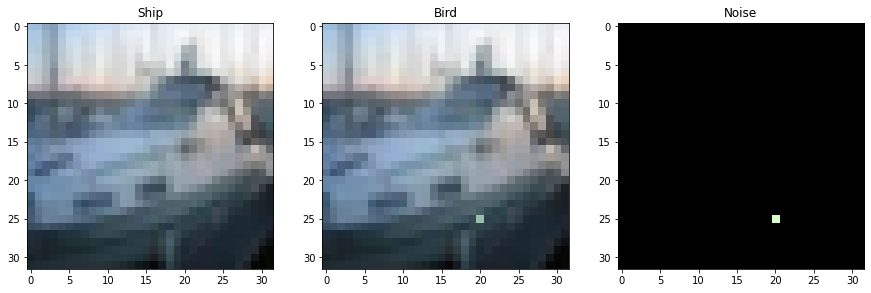

In [19]:
different_predictions = get_different_predictions(y_pred, y_pred_adv)
i = different_predictions[0]

plot_adversarial(testset, adv_dataset, y_pred, y_pred_adv, i)

## Evaluación en mobilenet_v2_adversarial

### Limpio

In [20]:
dataloader_eval  = torch.utils.data.DataLoader(testset, batch_size=None, shuffle=False, num_workers=4)

y_true, y_pred, accuracy_1, accuracy_5 = get_topk_accuracy(mobilenet_v2_adversarial, dataloader_eval)
print(f'Accuracy@1: {accuracy_1}')

100%|██████████| 10000/10000 [00:46<00:00, 217.03it/s]

Accuracy@1: 80.62


### FGSM

In [21]:
# The adversarial images are in [0,1], so NormalizationLayer prepares them for the pre-trained model 
adv_images, adv_labels = torch.load('models/FGSM_test.pt')
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true_adv, y_pred_adv, accuracy_1, accuracy_5 = get_topk_accuracy(mobilenet_v2_adversarial, adv_loader)
print(f'Accuracy@1: {accuracy_1}')

100%|██████████| 10000/10000 [00:49<00:00, 204.05it/s]

Accuracy@1: 77.44


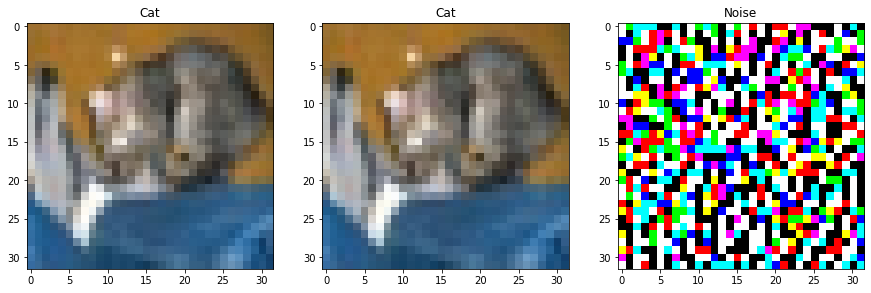

In [22]:
i = 0
plot_adversarial(testset, adv_dataset, y_pred, y_pred_adv, i)

### PGD

In [23]:
# The adversarial images are in [0,1], so NormalizationLayer prepares them for the pre-trained model 
adv_images, adv_labels = torch.load('models/PGD_test.pt')
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true_adv, y_pred_adv, accuracy_1, accuracy_5 = get_topk_accuracy(mobilenet_v2_adversarial, adv_loader)
print(f'Accuracy@1: {accuracy_1}')

100%|██████████| 10000/10000 [00:49<00:00, 200.93it/s]


Accuracy@1: 77.49000000000001


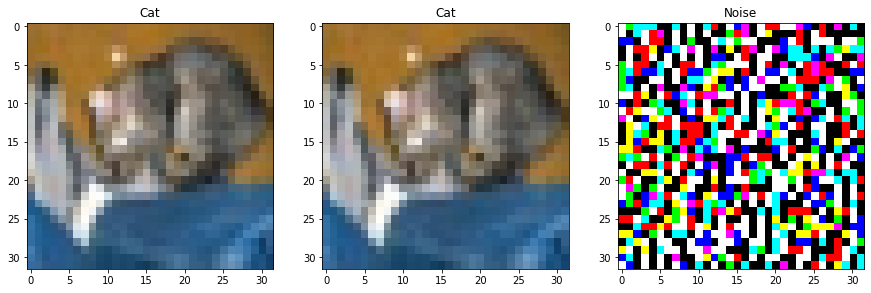

In [24]:
i = 0
plot_adversarial(testset, adv_dataset, y_pred, y_pred_adv, i)

### MIFGSM

In [25]:
# The adversarial images are in [0,1], so NormalizationLayer prepares them for the pre-trained model 
adv_images, adv_labels = torch.load('models/MIFGSM_test.pt')
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true_adv, y_pred_adv, accuracy_1, accuracy_5 = get_topk_accuracy(mobilenet_v2_adversarial, adv_loader)
print(f'Accuracy@1: {accuracy_1}')

100%|██████████| 10000/10000 [00:49<00:00, 200.33it/s]


Accuracy@1: 77.35


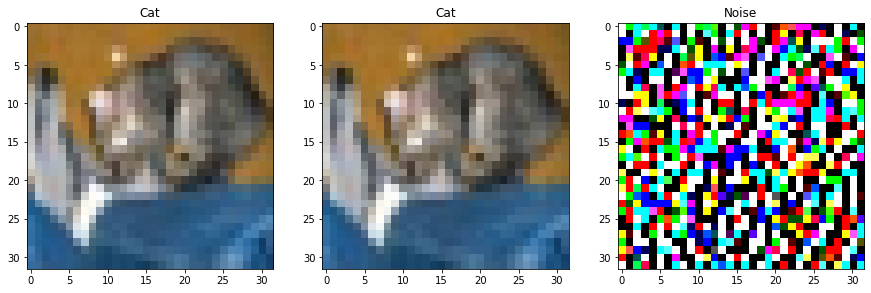

In [26]:
i = 0
plot_adversarial(testset, adv_dataset, y_pred, y_pred_adv, i)

### OnePixel

In [27]:
# The adversarial images are in [0,1], so NormalizationLayer prepares them for the pre-trained model 
adv_images, adv_labels = torch.load('models/OnePixel_test.pt')
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true_adv, y_pred_adv, accuracy_1, accuracy_5 = get_topk_accuracy(mobilenet_v2_adversarial, adv_loader)
print(f'Accuracy@1: {accuracy_1}')

100%|██████████| 10000/10000 [00:50<00:00, 196.21it/s]


Accuracy@1: 77.58


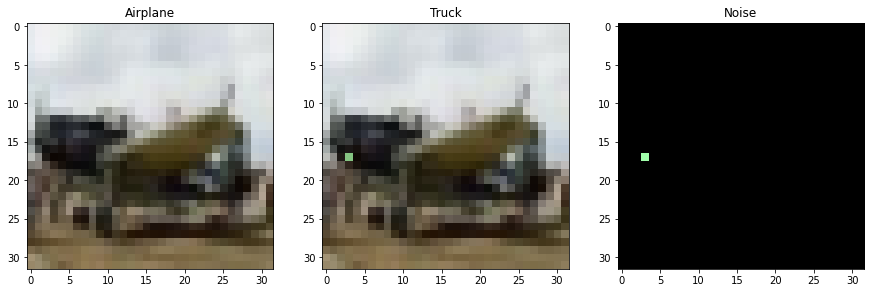

In [28]:
different_predictions = get_different_predictions(y_pred, y_pred_adv)
i = different_predictions[0]

plot_adversarial(testset, adv_dataset, y_pred, y_pred_adv, i)